In [1]:
# %env XLA_PYTHON_CLIENT_PREALLOCATE=false
import jax
import numpy as np
from deepmd_jax import md, utils
# jax.config.update('jax_enable_x64', True)
path = '/root/water_128_val/set.002/'
coord = np.load('/root/water_128_val/set.002/coord.npy')[0].reshape(384, 3)
box = np.load('/root/water_128_val/set.002/box.npy')[0,0]
type_idx = np.genfromtxt('/root/water_128_val/type.raw')
force = np.load('/root/water_128_val/set.002/force.npy')[0].reshape(384, 3)
energy = np.load('/root/water_128_val/set.002/energy.npy')[0]
coord, box, type_idx, force = utils.periodic_replicate(3, coord, box, type_idx, force)
sim = md.Simulation(
            model_path='/root/water_1M_all.pkl',
            box=box,
            type_idx=type_idx,
            mass=[15.9994, 1.0078],
            routine='NVE',
            dt=0.5,
            initial_position=coord,
            temperature=350,
            pressure=1,
      )
force_pred = sim.getForce()
print("# Force error: ", ((force - force_pred)**2).mean()**0.5)
# trajectory = sim.run(100)


2024-11-08 22:27:25.698228: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


# DeepMD-JAX: Starting on 1 device(s): [CudaDevice(id=0)]
# Model loaded from '/root/water_1M_all.pkl'.
# Initialized NVE simulation with 10368 atoms
# Neighborlist allocated with size [ 64 128], rcut_with_buffer = 7.0, buffer_ratio = 1.2
# Force error:  0.021061698933419346


In [2]:
import numpy as np
pos = np.load("bad_position.npy")

15.847165


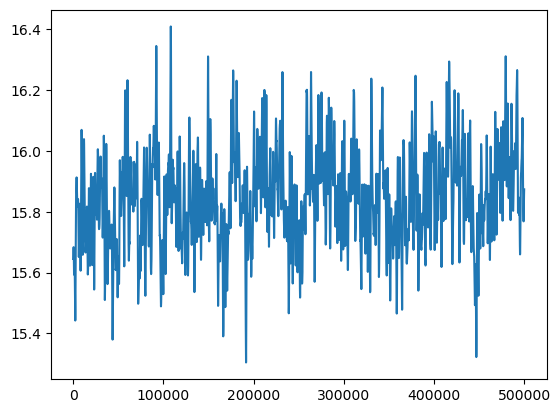

In [2]:
import matplotlib.pyplot as plt
print(trajectory['box'][:,0].mean())
plt.plot(trajectory['box'][:,0])

In [76]:
import jax.numpy as jnp
from jax import jit, vmap
# @jit
def get_nbr_full_idx(position, ref_nbrs):
    coord = jnp.array(position[sim._type_idx.argsort(kind='stable')])
    d = jnp.linalg.norm((coord[:, None] - coord[None] - box[0]/2) % box[0] - box[0]/2, axis=-1)
    mask = d < 6.
    idx = jnp.arange(mask.shape[0]) * jnp.ones_like(mask)
    idx = jnp.where(mask, idx, len(mask))
    idx = jnp.where(jnp.eye(len(mask), dtype=bool), len(mask), idx)
    idx00 = idx[:3456, :3456]
    idx01 = idx[:3456, 3456:]
    idx10 = idx[3456:, :3456]
    idx11 = idx[3456:, 3456:]
    idx01 = jnp.where(idx01 < len(mask), idx01 - 3456, len(mask))
    idx11 = jnp.where(idx11 < len(mask), idx11 - 3456, len(mask))
    idx = jnp.sort(idx, axis=1).astype(jnp.int32)
    idx00 = jnp.sort(idx00, axis=1).astype(jnp.int32)
    idx01 = jnp.sort(idx01, axis=1).astype(jnp.int32)
    idx10 = jnp.sort(idx10, axis=1).astype(jnp.int32)
    idx11 = jnp.sort(idx11, axis=1).astype(jnp.int32)
    # check if reference_idx is all in idx (for each row)
    check = vmap(lambda x, y: jnp.all(jnp.isin(x, y)))(idx, ref_nbrs.idx)
    check00 = vmap(lambda x, y: jnp.all(jnp.isin(x, y)))(idx00, ref_nbrs.nbrs_nm[0][0])
    check01 = vmap(lambda x, y: jnp.all(jnp.isin(x, y)))(idx01, ref_nbrs.nbrs_nm[0][1])
    check10 = vmap(lambda x, y: jnp.all(jnp.isin(x, y)))(idx10, ref_nbrs.nbrs_nm[1][0])
    check11 = vmap(lambda x, y: jnp.all(jnp.isin(x, y)))(idx11, ref_nbrs.nbrs_nm[1][1])
    return idx, (check.all(), check00.all(), check01.all(), check10.all(), check11.all())
# idx, check = get_nbr_full_idx(pos, nbrs.idx)
for i in range(len(trajectory['position'])):
# for i in range(1):
    sim.setPosition(trajectory['position'][i])
    idx, check = get_nbr_full_idx(trajectory['position'][i], sim._typed_nbrs)
    force_pred = sim.getForce()
    force_diff.append(np.linalg.norm(force_pred - inferred_force[i-1], axis=1).max())
    if not np.all(check).all():
        print(i)
        break

In [93]:
O = pos[::3]
H1 = pos[1::3]
H2 = pos[2::3]
dOH1 = np.linalg.norm((O - H1 + box[0]/6) % (box[0]/3) - box[0]/6, axis=1)
dOH2 = np.linalg.norm((O - H2 + box[0]/6) % (box[0]/3) - box[0]/6, axis=1)
# dOH1 = np.linalg.norm((O - H1 + box[0]/2) % box[0] - box[0]/2, axis=1)
# dOH2 = np.linalg.norm((O - H2 + box[0]/2) % box[0] - box[0]/2, axis=1)
print(dOH1)

[0.9945 0.9977 0.98   ... 0.9707 2.1359 0.9389]


15.64460095

In [60]:
sim._typed_nbrs.nbrs_nm

[(Array([[    2,     5,     8, ..., 10368, 10368, 10368],
         [   11,    35,    64, ..., 10368, 10368, 10368],
         [    0,     8,    12, ..., 10368, 10368, 10368],
         ...,
         [ 1895,  1932,  1936, ..., 10368, 10368, 10368],
         [  156,   347,   910, ..., 10368, 10368, 10368],
         [  596,   613,   718, ..., 10368, 10368, 10368]], dtype=int32),
  Array([[    0,     1,     4, ..., 10368, 10368, 10368],
         [    2,     3,    20, ..., 10368, 10368, 10368],
         [    0,     1,     4, ..., 10368, 10368, 10368],
         ...,
         [ 3790,  3791,  3872, ..., 10368, 10368, 10368],
         [  312,   313,   334, ..., 10368, 10368, 10368],
         [ 1192,  1193,  1226, ..., 10368, 10368, 10368]], dtype=int32)),
 (Array([[    0,     2,     5, ..., 10368, 10368, 10368],
         [    0,     2,     5, ..., 10368, 10368, 10368],
         [    1,    11,    35, ..., 10368, 10368, 10368],
         ...,
         [  156,   918,  1038, ..., 10368, 10368, 10368],

In [55]:
inferred_force = np.diff((trajectory['position'][1:] - trajectory['position'][:-1] - box[0]/2) % box[0] - box[0]/2, axis=0) / sim._dt**2 * sim._state.mass
force_diff = []
for i in range(1,len(trajectory['position'])-1):
    sim.setPosition(trajectory['position'][i])
    force_pred = sim.getForce()
    force_diff.append(np.linalg.norm(force_pred - inferred_force[i-1], axis=1).max())
print(np.array(force_diff).max())

0.06542322


In [54]:
# pos = sim.getPosition()
# nbrs = sim._typed_nbrs
# force = sim.getForce()
# vel = sim.getVelocity()
sim.setPosition(pos)
sim.setVelocity(vel)
sim.report_interval = 1
sim.step = 0
trajectory = sim.run(1000)

# Running 1000 steps...
0        374.490      501.879      -1616712.000 -1616210.125 0.001  0.218 
1        373.858      501.032      -1616710.750 -1616209.750 0.007  0.216 
2        372.390      499.065      -1616708.750 -1616209.625 0.007  0.214 
3        371.324      497.637      -1616706.750 -1616209.125 0.007  0.212 
4        371.881      498.383      -1616707.250 -1616208.875 0.007  0.209 
5        372.530      499.253      -1616708.000 -1616208.750 0.009  0.217 
6        372.982      499.858      -1616708.500 -1616208.625 0.007  0.215 
7        372.365      499.031      -1616708.000 -1616209.000 0.007  0.213 
8        371.300      497.604      -1616706.625 -1616209.000 0.007  0.211 
9        369.934      495.774      -1616704.625 -1616208.875 0.007  0.209 
10       368.477      493.821      -1616702.500 -1616208.625 0.009  0.217 
11       368.093      493.306      -1616702.125 -1616208.875 0.007  0.215 
12       368.576      493.954      -1616703.000 -1616209.000 0.007  0.212 
1

In [14]:
(sim._typed_nbrs.nbrs_nm[1][1] == 10368).sum(1).min()

Array(18, dtype=int32)

In [27]:
l, r = (box[0] - trajectory['position']).min((1,2)), trajectory['position'].min((1,2))
l[1000:2000].min()

9.092605424143585e-07

In [10]:
force = np.diff((trajectory['position'][1:] - trajectory['position'][:-1] - box[0]/2) % box[0] - box[0]/2, axis=0) / sim._dt**2 * sim._state.mass

In [52]:
i = 2046
sim.setPosition(trajectory['position'][i])
force_pred = sim.getForce()
(np.linalg.norm(force_pred - force[i-1], axis=1) > 1e-6).sum(), np.linalg.norm(force_pred - force[i-1], axis=1).max()

(564, 1.645687040159636)

In [77]:
i = 2046
sim.setPosition(trajectory['position'][i])
force_pred = sim.getForce()
print(i, np.linalg.norm(force_pred - force[i-1], axis=1).max())
nbr1 = sim._typed_nbrs.nbrs.idx
(sim._typed_nbrs.reference_position - trajectory['position'][i][sim._type_idx.argsort(kind='stable')]).max().item()

2046 1.6456870401596364


4.692690794195868e-06

In [94]:
min(dist_min), min(dist_max), max(dist_min), max(dist_max)

(0.9752360598380314, 3.0976747392608317, 7.324816185054714, 7.609559084887181)

In [101]:
i = 2046
coord = trajectory['position'][i][sim._type_idx.argsort(kind='stable')]
anomaly = []
for k in range(len(nbr1)):
    if len(np.setdiff1d(nbr0[k], nbr1[k])) > 0:
        idx = np.setdiff1d(nbr0[k], nbr1[k])
        dist = np.linalg.norm((coord[k] - coord[idx] - box[0]/2) % box - box[0]/2, axis=-1)
        if dist.min() < 6:
            anomaly.append(idx[dist.argmin()])
anomaly = np.array(anomaly)
anomaly

array([7887, 7887, 7887, 7887, 7887, 7887, 7887, 7887, 7887, 7887, 7887,
       7887, 7887, 7887, 7887, 7887, 7887, 7887, 7887, 7887, 7887, 7887,
       7887, 7887, 7887, 7887, 7887, 7887, 7887, 7887, 7887, 7887, 7887,
       7887, 7887, 7887, 7887, 7887, 7887, 7887, 7887, 7887, 7887, 7887,
       7887, 7887, 7887, 7887, 7887, 7887, 7887, 7887, 7887, 7887, 7887,
       7887, 7887, 7887, 7887, 7887, 7887, 7887, 7887, 7887, 7887, 7887,
       7887, 7887, 7887, 7887, 7887, 7887, 7887, 7887, 7887, 7887, 7887,
       7887, 7887, 7887, 7887, 7887, 1831, 7887, 7887, 7887, 7887, 7887],
      dtype=int32)

In [112]:
sim._typed_nbrs.did_buffer_overflow

Array(2, dtype=uint8)

In [107]:
(coord[7887]  / box[0]) * 100 * (1-2e-7) + 1e-7, (coord[1831]  / box[0]) * 100

(array([0.01  , 0.6599, 0.3848]), array([ 1.2222, 64.5355, 39.9493]))

In [76]:
import matplotlib.pyplot as plt
for i in range(2000, 2100):
    sim.setPosition(trajectory['position'][i])
    force_pred = sim.getForce()
    print(i, np.linalg.norm(force_pred - force[i-1], axis=1).max())
    if i == 2046:
        nbr0 = sim._typed_nbrs.nbrs.idx

2000 9.89595869176659e-11
2001 9.878086950292251e-11
2002 1.031296849455298e-10
2003 1.1073204451779984e-10
2004 1.0746800169407537e-10
2005 1.0351639474204759e-10
2006 1.0749313048858633e-10
2007 9.796716144918731e-11
2008 9.919648146088687e-11
2009 1.0167316067767401e-10
2010 9.44125649585879e-11
2011 9.070749693782717e-11
2012 1.0396135493888135e-10
2013 9.661879698997012e-11
2014 1.0793840965225327e-10
2015 1.0199307184067111e-10
2016 1.0147123774985237e-10
2017 1.0652272516017695e-10
2018 9.480921884480055e-11
2019 9.144291543379792e-11
2020 9.679402687500498e-11
2021 1.0295478633508574e-10
2022 8.969516879083032e-11
2023 9.184944039653756e-11
2024 1.0038140094745256e-10
2025 9.887891339759204e-11
2026 9.626706741784395e-11
2027 1.003592701516594e-10
2028 9.096362945723626e-11
2029 9.915373113404779e-11
2030 1.0021764509628532e-10
2031 9.063077814365538e-11
2032 1.07879437466742e-10
2033 9.820567471945134e-11
2034 9.830582310414069e-11
2035 9.013530178612023e-11
2036 9.49482996147

In [47]:
for i in range(2000, 2100):
    sim.setPosition(trajectory['position'][i])
    KE = (0.5 * (trajectory['velocity'][i]**2).sum(-1) * sim._state.mass[:,0]).sum()
    print(i, KE + sim.getEnergy())

2850 -1616254.5
2851 -1616254.5
2852 -1616254.4
2853 -1616254.5
2854 -1616254.6
2855 -1616254.6
2856 -1616254.8
2857 -1616254.6
2858 -1616254.6
2859 -1616254.6
2860 -1616242.6
2861 -1616242.8
2862 -1616242.9
2863 -1616242.9
2864 -1616242.9
2865 -1616242.9
2866 -1616242.9
2867 -1616242.9
2868 -1616242.8
2869 -1616242.8


In [68]:
for i in range(2800, 2840):
    inferred_force = (trajectory['velocity'][i+1] - trajectory['velocity'][i]) / sim._dt * sim._state.mass
    sim.setPosition(trajectory['position'][i])
    force = sim.getForce()
    print(i, "Force error: ", np.abs(force - inferred_force).max())

2800 Force error:  0.97504497
2801 Force error:  0.8837359
2802 Force error:  0.93043745
2803 Force error:  0.89591396
2804 Force error:  0.99461436
2805 Force error:  1.0223017
2806 Force error:  0.90029705
2807 Force error:  0.9747851
2808 Force error:  0.82132244
2809 Force error:  0.9220722
2810 Force error:  0.9522153
2811 Force error:  0.8371465
2812 Force error:  0.8888793
2813 Force error:  0.8675201
2814 Force error:  0.80442274
2815 Force error:  0.83995676
2816 Force error:  0.84679943
2817 Force error:  1.0673771
2818 Force error:  1.2094462
2819 Force error:  0.9760041
2820 Force error:  0.79002905
2821 Force error:  0.85533226
2822 Force error:  1.0696497
2823 Force error:  1.1657763
2824 Force error:  0.9609434
2825 Force error:  0.91133356
2826 Force error:  0.8538213
2827 Force error:  0.80603504
2828 Force error:  0.8762171
2829 Force error:  0.8828827
2830 Force error:  0.9170778
2831 Force error:  0.87284255
2832 Force error:  0.83708084
2833 Force error:  0.8144096

In [67]:
for i in range(2840, 2862):
    inferred_force = (trajectory['velocity'][i+1] - trajectory['velocity'][i]) / sim._dt * sim._state.mass
    sim.setPosition(trajectory['position'][i])
    force = sim.getForce()
    print(i, "Force error: ", np.abs(force - inferred_force).max())

2840 Force error:  0.87853324
2841 Force error:  1.0347335
2842 Force error:  1.0712049
2843 Force error:  0.9619553
2844 Force error:  0.89485407
2845 Force error:  0.8765799
2846 Force error:  0.84623015
2847 Force error:  0.9560535
2848 Force error:  0.9807074
2849 Force error:  0.98636043
2850 Force error:  0.9105789
2851 Force error:  0.8597729
2852 Force error:  0.80490226
2853 Force error:  0.8352667
2854 Force error:  0.82146215
2855 Force error:  3.1362731
2856 Force error:  3.1880622
2857 Force error:  3.1163244
2858 Force error:  2.9204006
2859 Force error:  2.5967531
2860 Force error:  2.357224
2861 Force error:  1.3088533


In [63]:
force

Array([[-1.6955, -2.0594,  3.4863],
       [ 2.2445,  0.3945,  0.1828],
       [-0.6544,  1.4966, -2.9367],
       ...,
       [-0.5568, -1.5826, -0.468 ],
       [ 0.0385, -0.2484, -0.2911],
       [-0.7005,  1.2155,  0.0232]], dtype=float32)

In [86]:
# pos = trajectory['position'][2858]
margin = np.maximum(box[0] - trajectory['position'].max((1,2)), trajectory['position'].min((1,2)))
margin = box[0] - trajectory['position'].max((1,2))
(margin[2000:2860] * 1000).argmin(), margin[2800]

(175, 9.1552734e-05)

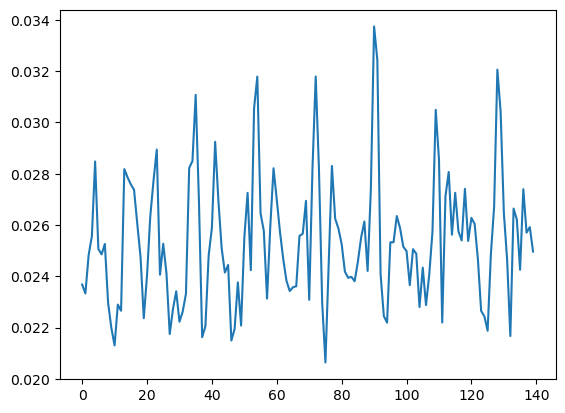

In [50]:
import matplotlib.pyplot as plt
force = trajectory['velocity'][1:] - trajectory['velocity'][:-1]
force_max = np.linalg.norm(force, axis=-1).max(axis=-1)
plt.plot(force_max[2730:2870])

In [5]:
import numpy as onp
import jax
jax.config.update('jax_enable_x64', True)
import jax.numpy as np
from jax import random
from jax import jit
from jax import lax
from jax import ops
import time
from jax_md import space, smap, energy, minimize, quantity, simulate
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
onp.set_printoptions(precision=4, suppress=True)
sns.set_style(style='white')
def format_plot(x, y):  
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)
def finalize_plot(shape=(1, 1)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()
N = 400
dimension = 2
factor = 1
box = quantity.box_size_at_number_density(N, 0.8, 2) * factor * 1.1
dt = 5e-3
displacement, shift = space.periodic_general(box, fractional_coordinates=True)
kT = np.float32(0.01)
P = lambda t: 0.05
key = random.PRNGKey(0)
key, split = random.split(key)
R = random.uniform(split, (N, dimension), dtype=np.float64)
sigma = np.array([[1.0, 1.2], [1.2, 1.4]]) * factor
N_2 = int(N / 2)
species = np.where(np.arange(N) < N_2, 0, 1)
energy_fn = energy.soft_sphere_pair(displacement, species=species, sigma=sigma)
init, apply = simulate.npt_nose_hoover(energy_fn, shift, dt, P(0.), kT)
state = init(key, R, box)